In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from itertools import product
from competition.titanic.FeaturesEngineering import *
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("error", category=FutureWarning)

from sklearn.pipeline import Pipeline

(891, 11)
(891,)


In [2]:
df = pd.read_csv("../data/train.csv", delimiter=",")

features = [x for x in df.columns if x != "Survived"]
x, y = df[features], df["Survived"].T
print(x.shape)
print(y.shape)

(891, 11)
(891,)


In [3]:
X_train, X_cv, y_train, y_cv = train_test_split(x, y, train_size=0.8, random_state=1)

In [4]:
max_depth_list = [2, 3, 4, 5, 6, 7, 8]
min_child_weight_list = [10, 20, 30, 40, 50]
n_estimators_list = [50, 100, 150, 200]
colsample_bytree_list = [0.6, 0.8, 1]
reg_lambda_list = [0, 0.1, 1, 5, 10]
reg_alpha_list = [0, 0.1, 1]


def eval_models(X_train, y_train, X_cv, y_cv,
                max_depth,
                min_child_weight,
                n_estimators,
                colsample_bytree,
                reg_alpha,
                reg_lambda,
                feature_transformer):
    model = Pipeline(steps=[
        ("preprocessor", feature_transformer),
        ("classifier", XGBClassifier(n_estimators=n_estimators,
                                     learning_rate=0.1,
                                     max_depth=max_depth,
                                     min_child_weight=min_child_weight,
                                     colsample_bytree=colsample_bytree,
                                     reg_lambda=reg_lambda,
                                     reg_alpha=reg_alpha,
                                     random_state=1))
    ])
    model.fit(X_train, y_train)
    y_train_hat = model.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_hat)
    y_cv_hat = model.predict(X_cv)
    cv_accuracy = np.mean(y_cv == y_cv_hat)
    print(
        f"Max depth: {max_depth}, n_estimators: {n_estimators}, min_child_weight: {min_child_weight}, colsample_bytree: {colsample_bytree},reg_lambda: {reg_lambda},reg_alpha: {reg_alpha}, train_accuracy: {train_accuracy}, cv_accuracy: {cv_accuracy}")
    return model, train_accuracy, cv_accuracy


# for max_depth, min_child_weight, n_estimators, colsample_bytree in product(max_depth_list, min_child_weight_list, n_estimators_list, colsample_bytree_list):
#     eval_models(X_train, y_train, X_cv, y_cv, max_depth, min_child_weight, n_estimators, colsample_bytree, engineer_features())
model_evals = [eval_models(X_train, y_train, X_cv, y_cv, max_depth, min_child_weight, n_estimators, colsample_bytree, reg_lambda, reg_alpha, engineer_features()) for max_depth, min_child_weight, n_estimators, colsample_bytree, reg_lambda, reg_alpha in
     product(max_depth_list, min_child_weight_list, n_estimators_list, colsample_bytree_list, reg_lambda_list, reg_alpha_list)]
best_model_params = max(model_evals, key=lambda x: x[2])
print(best_model_params[-2:])

Max depth: 2, n_estimators: 50, min_child_weight: 10, colsample_bytree: 0.6,reg_lambda: 0,reg_alpha: 0, train_accuracy: 0.8455056179775281, cv_accuracy: 0.7877094972067039
Max depth: 2, n_estimators: 50, min_child_weight: 10, colsample_bytree: 0.6,reg_lambda: 0.1,reg_alpha: 0, train_accuracy: 0.8412921348314607, cv_accuracy: 0.7821229050279329
Max depth: 2, n_estimators: 50, min_child_weight: 10, colsample_bytree: 0.6,reg_lambda: 1,reg_alpha: 0, train_accuracy: 0.8426966292134831, cv_accuracy: 0.770949720670391
Max depth: 2, n_estimators: 50, min_child_weight: 10, colsample_bytree: 0.6,reg_lambda: 0,reg_alpha: 0.1, train_accuracy: 0.8426966292134831, cv_accuracy: 0.770949720670391
Max depth: 2, n_estimators: 50, min_child_weight: 10, colsample_bytree: 0.6,reg_lambda: 0.1,reg_alpha: 0.1, train_accuracy: 0.8441011235955056, cv_accuracy: 0.770949720670391
Max depth: 2, n_estimators: 50, min_child_weight: 10, colsample_bytree: 0.6,reg_lambda: 1,reg_alpha: 0.1, train_accuracy: 0.84269662921

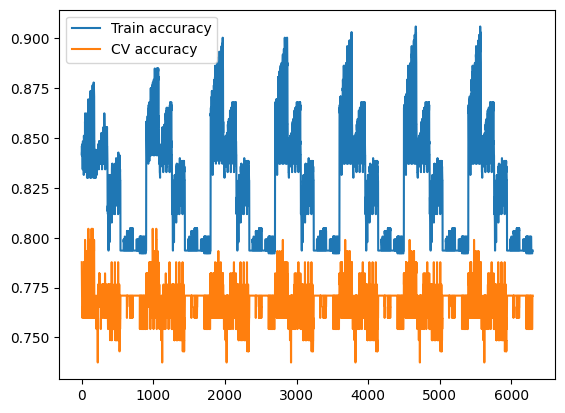

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
train_accuracy = [model[1] for model in model_evals]
cv_accuracy =[model[2] for model in model_evals]
plt.plot(range(len(model_evals)), train_accuracy)
plt.plot(range(len(model_evals)), cv_accuracy)
plt.legend(["Train accuracy", "CV accuracy"])
plt.show()

In [8]:
df_test = pd.read_csv("../data/test.csv", delimiter=",")

best_model = best_model_params[0]
y_test_hat = best_model.predict(df_test)
output = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": y_test_hat
})
output.to_csv("xgb_submission.csv", index=False)